# Preliminary operations

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#%cd /gdrive/MyDrive/POLIMI/ANN and DL/Homework1
%cd /gdrive/MyDrive/ko
!ls

/gdrive/MyDrive/ko
 balanced_dataset_1000	     'Part5 - more.ipynb'
 dataset_homework1	     'sicurezza (1).ipynb'
 hp_tuning		      training_data_final
 models			      training_dataset_homework1.zip
'Part1 - Dataset (2).ipynb'


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

!pip install visualkeras
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 40.3 MB/s 
2.9.2


# Common definitions

In [ ]:
aug_generator = ImageDataGenerator(rotation_range=180,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=[0.6,1.4],
                                    fill_mode='reflect',
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    #rescale=1/255.,
                                    preprocessing_function=None, #Included in the NN
                                   )

In [ ]:
def define_generators(directory, bs, aug_gen):

  generators = {}
  training_dir = os.path.join(directory, 'train') 
  validation_dir = os.path.join(directory, 'val') 
  test_dir = os.path.join(directory, 'test') 

  generators['train'] = aug_gen.flow_from_directory(directory=training_dir,
                                                        target_size=(96,96),
                                                        color_mode='rgb',
                                                        classes=None,
                                                        class_mode='categorical',
                                                        batch_size=bs,
                                                        shuffle=True,
                                                        seed=seed)


  # VALIDATION SET
  generators['val'] = ImageDataGenerator(#rescale=1/255.
                                         ).flow_from_directory(directory=validation_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  # TEST SET
  generators['test'] = ImageDataGenerator(#rescale=1/255.
                                          ).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  return generators

In [ ]:
labels = {
    0:'Species1', 
    1:'Species2', 
    2:'Species3', 
    3:'Species4', 
    4:'Species5', 
    5:'Species6',
    6:'Species7', 
    7:'Species8'}

In [ ]:
input_shape = (96, 96, 3)
output_dim = 8
epochs = 200
mtrcs = ['accuracy']
monmtr = 'val_accuracy'

In [ ]:
def evaluate_model(model_name, test_set, target):
  model = tfk.models.load_model(model_name)
  predictions = model.predict(test_set)
  metrics= {
    "model": model_name,
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true'),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Model: "+ str(metrics["model"]))
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(10,8))
  sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Hyperparameters tuning DenseNet

In [ ]:
%pip install keras-tuner --upgrade
import keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 32.0 MB/s 
     |████████████████████████████████| 1.6 MB 48.0 MB/s 


In [ ]:
dataset_dir = "dataset_homework1"
bs = 64

In [ ]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
def build_model(hp):

  input_shape = (96, 96, 3)
  output_dim = 8
  epochs = 200
  mtrcs = ['accuracy']
  monmtr = 'val_accuracy'
  dataset_dir = "dataset_homework1"
  bs = 64

  # Augmentation
  training_dir = os.path.join(dataset_dir, 'train') 
  validation_dir = os.path.join(dataset_dir, 'val') 
  test_dir = os.path.join(dataset_dir, 'test') 

  train_gen = ImageDataGenerator(featurewise_center=hp.Boolean("featurewise_center"),
                                    samplewise_center=hp.Boolean("samplewise_center"),
                                    featurewise_std_normalization=hp.Boolean("featurewise_std_normalization"),
                                    samplewise_std_normalization=hp.Boolean("samplewise_std_normalization"),
                                    zca_whitening=hp.Boolean("zca_whitening"),
                                    rotation_range=hp.Int("rotation_range",min_value=0,max_value=360,step=10),
                                    width_shift_range=hp.Choice("width_shift_range",[0.0,0.2]),
                                    height_shift_range=hp.Choice("height_shift_range",[0.0,0.2]),
                                    brightness_range=[0.2,hp.Float("max_rotation",min_value=0.3,max_value=1.4)],
                                    zoom_range=hp.Float("zoom_range",min_value=0,max_value=1),
                                    fill_mode=hp.Choice("fill_mode",['nearest','constant','wrap','reflect']),
                                    horizontal_flip=hp.Boolean("horizontal_flip"),
                                    vertical_flip=hp.Boolean("vertical_flip")
                                              ).flow_from_directory(directory=training_dir,
                                                        target_size=(96,96),
                                                        color_mode='rgb',
                                                        classes=None,
                                                        class_mode='categorical',
                                                        batch_size=bs,
                                                        shuffle=True,
                                                        seed=seed)


  # VALIDATION SET
  valid_gen = ImageDataGenerator(#rescale=1/255.
                                         ).flow_from_directory(directory=validation_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  # TEST SET
  test_gen = ImageDataGenerator(#rescale=1/255.
                                          ).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)


  # Model
  supernet = tf.keras.applications.densenet.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=input_shape,
      pooling='avg'
  )
  
  l2 = hp.Float("reg", min_value=1e-5, max_value=1e-2, sampling="log")
  dpc = hp.Float("drop_rate_class", min_value=0.1, max_value=0.5, sampling="log")
  dpo = hp.Float("drop_rate_out", min_value=0.1, max_value=0.5, sampling="log")

  ## Supernet + top
  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tfk.applications.densenet.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.GlobalAveragePooling2D()(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(dpc, seed=seed)(x)

  x = tfkl.Dense(
      units=hp.Int("units", min_value=128, max_value=512, step=32), 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed),
      #kernel_regularizer=tf.keras.regularizers.L1L2(l2,l2),
      kernel_regularizer=tf.keras.regularizers.l2(l2)
      )(x)

  x = tfkl.Dropout(dpo, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      #kernel_regularizer=tf.keras.regularizers.L1L2(l2,l2),
      kernel_regularizer=tf.keras.regularizers.l2(l2)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  learning_rate = hp.Float("lr", min_value=1e-8, max_value=1e-4, sampling="log")
  eps = hp.Float("epsilon", min_value=1e-7, max_value=1e-1, sampling="log")

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate,eps), metrics=mtrcs)

  tn = 'densenet121'

  d = 404
  model.get_layer(tn).trainable = True
  for i, layer in enumerate(model.get_layer(tn).layers[:d]):
    layer.trainable=False
  # for i, layer in enumerate(model.get_layer(tn).layers):
  #   print(i, layer.name, layer.trainable)
  # for i, layer in enumerate(model.layers):
  #  print(i, layer.name, layer.trainable)

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate,eps), metrics=mtrcs)

  return (model)

In [ ]:
info = build_model(keras_tuner.HyperParameters()) 

tuner = keras_tuner.RandomSearch(
    hypermodel= build_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    overwrite=True,
    directory="hp_tuning",
    project_name="hp tuning chiara",
)

Found 2691 images belonging to 8 classes.
Found 301 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
Found 2691 images belonging to 8 classes.
Found 301 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
tuner.search(train_gen,epochs=2, validation_data=valid_gen)
tuner.results_summary() 

Trial 20 Complete [00h 01m 23s]
val_accuracy: 0.12956809997558594

Best val_accuracy So Far: 0.3255813866853714
Total elapsed time: 00h 34m 15s
Results summary
Results in hp_tuning/hp tuning chiara
Showing 10 best trials
Trial summary
Hyperparameters:
featurewise_center: False
samplewise_center: True
featurewise_std_normalization: False
samplewise_std_normalization: False
zca_whitening: True
rotation_range: 120
width_shift_range: 0.0
height_shift_range: 0.2
max_rotation: 0.3449658419684163
zoom_range: 0.4740901529002568
fill_mode: nearest
horizontal_flip: True
vertical_flip: False
reg: 1.8787538488618725e-05
drop_rate_class: 0.2752650641719181
drop_rate_out: 0.12294747416332714
units: 352
lr: 5.171117614770422e-05
epsilon: 3.142143808026855e-06
Score: 0.3255813866853714
Trial summary
Hyperparameters:
featurewise_center: True
samplewise_center: True
featurewise_std_normalization: False
samplewise_std_normalization: False
zca_whitening: True
rotation_range: 170
width_shift_range: 0.0
hei

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(96,96,3))
best_model.summary()

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
           

In [ ]:
from sklearn.utils import  compute_class_weight
class_weights =  compute_class_weight(class_weight = "balanced",
                              classes = np.unique(train_target),
                              y = train_target)
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))
class_weights

{0: 2.272804054054054,
 1: 0.7914705882352941,
 2: 0.8164441747572816,
 3: 0.8244485294117647,
 4: 0.7933372641509434,
 5: 1.9004237288135593,
 6: 0.7840909090909091,
 7: 1.2551305970149254}

In [ ]:
# Train the model
best_history = best_model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight=class_weights,
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-11),
    ] 
).history


Epoch 1/200
43/43 [==============================] - 20s 323ms/step - loss: 2.1643 - accuracy: 0.2847 - val_loss: 1.6766 - val_accuracy: 0.3953 - lr: 5.1711e-05
Epoch 2/200
43/43 [==============================] - 12s 273ms/step - loss: 1.9604 - accuracy: 0.3333 - val_loss: 1.5407 - val_accuracy: 0.4419 - lr: 5.1711e-05
Epoch 3/200
43/43 [==============================] - 12s 273ms/step - loss: 1.8517 - accuracy: 0.3698 - val_loss: 1.4246 - val_accuracy: 0.4950 - lr: 5.1711e-05
Epoch 4/200
43/43 [==============================] - 13s 298ms/step - loss: 1.7464 - accuracy: 0.4043 - val_loss: 1.3467 - val_accuracy: 0.5216 - lr: 5.1711e-05
Epoch 5/200
43/43 [==============================] - 12s 274ms/step - loss: 1.6291 - accuracy: 0.4422 - val_loss: 1.2590 - val_accuracy: 0.5482 - lr: 5.1711e-05
Epoch 6/200
43/43 [==============================] - 12s 275ms/step - loss: 1.5579 - accuracy: 0.4604 - val_loss: 1.2212 - val_accuracy: 0.5548 - lr: 5.1711e-05
Epoch 7/200
43/43 [===============

In [ ]:
best_model.save('models/densenet_1')

### Fine tuning

In [ ]:
!ls 

In [ ]:
old_model_name = "models/densenet_1"
new_model_name = "models/densenet_1_finetuned"

In [ ]:
# Re-load the model after transfer learning
old_model = tfk.models.load_model(old_model_name)

In [ ]:
old_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0     

In [ ]:
# Set all layers to trainable
tn = 'densenet121'
for i, layer in enumerate(old_model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

In [ ]:
for i, layer in enumerate(old_model.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
l_rate = 1e-8
eps = 1e-07
old_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate, epsilon=eps), metrics=mtrcs)

In [ ]:
history = old_model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-11),
    ] 
).history

Epoch 1/200
43/43 [==============================] - 22s 384ms/step - loss: 0.7560 - accuracy: 0.7454 - val_loss: 0.6471 - val_accuracy: 0.8040 - lr: 1.0000e-08
Epoch 2/200
43/43 [==============================] - 15s 344ms/step - loss: 0.7376 - accuracy: 0.7521 - val_loss: 0.6487 - val_accuracy: 0.8073 - lr: 1.0000e-08
Epoch 3/200
43/43 [==============================] - 12s 272ms/step - loss: 0.7460 - accuracy: 0.7436 - val_loss: 0.6478 - val_accuracy: 0.8007 - lr: 1.0000e-08
Epoch 4/200
43/43 [==============================] - 12s 273ms/step - loss: 0.6938 - accuracy: 0.7670 - val_loss: 0.6494 - val_accuracy: 0.8040 - lr: 1.0000e-08
Epoch 5/200
43/43 [==============================] - 13s 297ms/step - loss: 0.7474 - accuracy: 0.7611 - val_loss: 0.6516 - val_accuracy: 0.8007 - lr: 1.0000e-08
Epoch 6/200
43/43 [==============================] - 12s 273ms/step - loss: 0.7424 - accuracy: 0.7462 - val_loss: 0.6522 - val_accuracy: 0.8040 - lr: 1.0000e-08
Epoch 7/200
43/43 [===============

In [ ]:
old_model.save(new_model_name)

6/6 [==============================] - 50s 10s/step
Model: models/densenet_1_finetuned
Accuracy: 0.7569060773480663
F1 score: 0.742133562503226


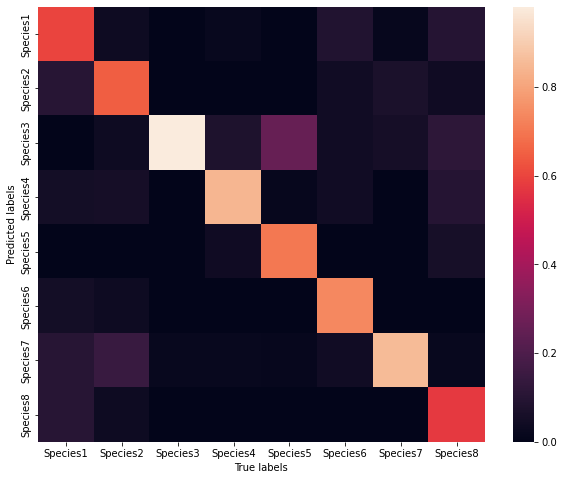

In [ ]:
ret = evaluate_model(new_model_name, test_gen, test_target_cat)

### Fine tuning

In [ ]:
!ls 

In [ ]:
old_model_name = "models/densenet_1"
new_model_name = "models/densenet_1_finetuned"

In [ ]:
# Re-load the model after transfer learning
old_model = tfk.models.load_model(old_model_name)

In [ ]:
old_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0     

In [ ]:
# Set all layers to trainable
tn = 'densenet121'
for i, layer in enumerate(old_model.get_layer(tn).layers):
   print(i, layer.name, layer.trainable)

In [ ]:
for i, layer in enumerate(old_model.layers):
   print(i, layer.name, layer.trainable)

In [ ]:
l_rate = 1e-8
eps = 1e-07
old_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=l_rate, epsilon=eps), metrics=mtrcs)

In [ ]:
history = old_model.fit(
    x = train_gen,
    epochs = epochs,
    class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-11),
    ] 
).history

Epoch 1/200
43/43 [==============================] - 22s 384ms/step - loss: 0.7560 - accuracy: 0.7454 - val_loss: 0.6471 - val_accuracy: 0.8040 - lr: 1.0000e-08
Epoch 2/200
43/43 [==============================] - 15s 344ms/step - loss: 0.7376 - accuracy: 0.7521 - val_loss: 0.6487 - val_accuracy: 0.8073 - lr: 1.0000e-08
Epoch 3/200
43/43 [==============================] - 12s 272ms/step - loss: 0.7460 - accuracy: 0.7436 - val_loss: 0.6478 - val_accuracy: 0.8007 - lr: 1.0000e-08
Epoch 4/200
43/43 [==============================] - 12s 273ms/step - loss: 0.6938 - accuracy: 0.7670 - val_loss: 0.6494 - val_accuracy: 0.8040 - lr: 1.0000e-08
Epoch 5/200
43/43 [==============================] - 13s 297ms/step - loss: 0.7474 - accuracy: 0.7611 - val_loss: 0.6516 - val_accuracy: 0.8007 - lr: 1.0000e-08
Epoch 6/200
43/43 [==============================] - 12s 273ms/step - loss: 0.7424 - accuracy: 0.7462 - val_loss: 0.6522 - val_accuracy: 0.8040 - lr: 1.0000e-08
Epoch 7/200
43/43 [===============

In [ ]:
old_model.save(new_model_name)

6/6 [==============================] - 50s 10s/step
Model: models/densenet_1_finetuned
Accuracy: 0.7569060773480663
F1 score: 0.742133562503226


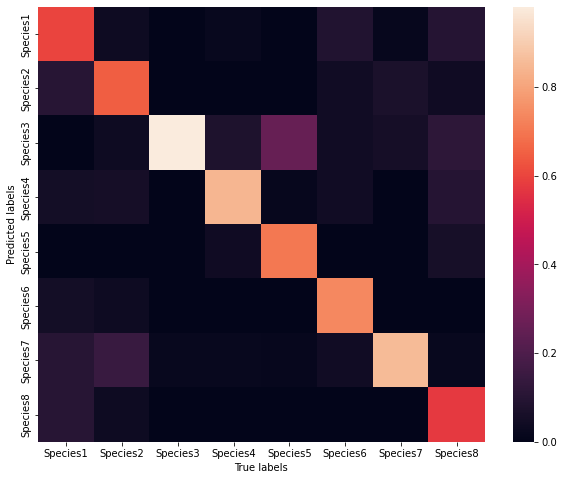

In [ ]:
ret = evaluate_model(new_model_name, test_gen, test_target_cat)

# Hyperparameters tuning2 DenseNet

In [ ]:
%pip install keras-tuner --upgrade
import keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!ls

 balanced_dataset_1000	     'Part5 - more.ipynb'
 dataset_homework1	     'sicurezza (1).ipynb'
 hp_tuning		      training_data_final
 models			      training_dataset_homework1.zip
'Part1 - Dataset (2).ipynb'


In [ ]:
dataset_dir = "balanced_dataset_1000"
bs = 128

In [ ]:
gens = define_generators(dataset_dir, bs, aug_generator)

train_gen = gens['train']
valid_gen = gens['val']
test_gen = gens['test']

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

Found 8000 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
!ls models

densenet_1  densenet_1_finetuned


3/3 [==============================] - 79s 35s/step
Model: models/densenet_1_finetuned
Accuracy: 0.7569060773480663
F1 score: 0.742133562503226


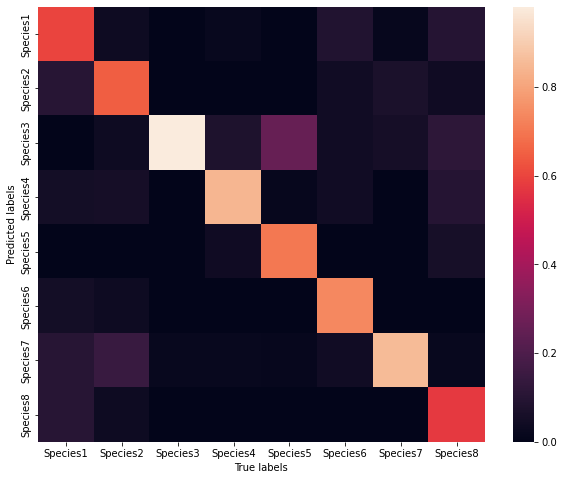

In [ ]:
ret = evaluate_model("models/densenet_1_finetuned", test_gen, test_target_cat)

In [ ]:
bm = tfk.models.load_model("models/densenet_1_finetuned")
bm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0     

In [ ]:
def build_model(hp):

  input_shape = (96, 96, 3)
  output_dim = 8
  epochs = 200
  mtrcs = ['accuracy']
  monmtr = 'val_accuracy'
  dataset_dir = "balanced_dataset_1000"
  bs = 128

  # Augmentation
  training_dir = os.path.join(dataset_dir, 'train') 
  validation_dir = os.path.join(dataset_dir, 'val') 
  test_dir = os.path.join(dataset_dir, 'test') 

  train_gen = ImageDataGenerator(featurewise_center=hp.Boolean("featurewise_center"),
                                    samplewise_center=hp.Boolean("samplewise_center"),
                                    featurewise_std_normalization=hp.Boolean("featurewise_std_normalization"),
                                    samplewise_std_normalization=hp.Boolean("samplewise_std_normalization"),
                                    zca_whitening=hp.Boolean("zca_whitening"),
                                    rotation_range=hp.Int("rotation_range",min_value=0,max_value=360,step=10),
                                    width_shift_range=hp.Choice("width_shift_range",[0.0,0.2]),
                                    height_shift_range=hp.Choice("height_shift_range",[0.0,0.2]),
                                    brightness_range=[0.2,hp.Float("max_rotation",min_value=0.3,max_value=1.4)],
                                    zoom_range=hp.Float("zoom_range",min_value=0,max_value=1),
                                    fill_mode=hp.Choice("fill_mode",['nearest','constant','wrap','reflect']),
                                    horizontal_flip=hp.Boolean("horizontal_flip"),
                                    vertical_flip=hp.Boolean("vertical_flip")
                                              ).flow_from_directory(directory=training_dir,
                                                        target_size=(96,96),
                                                        color_mode='rgb',
                                                        classes=None,
                                                        class_mode='categorical',
                                                        batch_size=bs,
                                                        shuffle=True,
                                                        seed=seed)


  # VALIDATION SET
  valid_gen = ImageDataGenerator(#rescale=1/255.
                                         ).flow_from_directory(directory=validation_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)

  # TEST SET
  test_gen = ImageDataGenerator(#rescale=1/255.
                                          ).flow_from_directory(directory=test_dir,
                                                target_size=(96,96),
                                                color_mode='rgb',
                                                classes=None,
                                                class_mode='categorical',
                                                batch_size=bs,
                                                shuffle=False,
                                                seed=seed)


  # Model
  supernet = tf.keras.applications.densenet.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=input_shape,
      pooling='avg'
  )
  
  l2 = hp.Float("reg", min_value=1e-5, max_value=1e-2, sampling="log")
  dpc = hp.Float("drop_rate_class", min_value=0.1, max_value=0.5, sampling="log")
  dpo = hp.Float("drop_rate_out", min_value=0.1, max_value=0.5, sampling="log")

  ## Supernet + top
  supernet.trainable = False
  
  inputs = tfk.Input(shape=input_shape)
  x = tfk.applications.densenet.preprocess_input(inputs)

  x = supernet(x)
  #x = tfk.layers.GlobalAveragePooling2D()(x)
  x = tfk.layers.Flatten()(x)
  x = tfkl.Dropout(dpc, seed=seed)(x)

  x = tfkl.Dense(
      units=hp.Int("units", min_value=128, max_value=512, step=32), 
      name='Classifier_layer',
      activation='relu',
      kernel_initializer = tfk.initializers.HeUniform(seed),
      #kernel_regularizer=tf.keras.regularizers.L1L2(l2,l2),
      kernel_regularizer=tf.keras.regularizers.l2(l2)
      )(x)

  x = tfkl.Dropout(dpo, seed=seed)(x)
  outputs = tfkl.Dense(
      output_dim, 
      name='Output_layer',
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed),
      #kernel_regularizer=tf.keras.regularizers.L1L2(l2,l2),
      kernel_regularizer=tf.keras.regularizers.l2(l2)
      )(x)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  learning_rate = hp.Float("lr", min_value=1e-8, max_value=1e-4, sampling="log")
  eps = hp.Float("epsilon", min_value=1e-7, max_value=1e-1, sampling="log")

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate,eps), metrics=mtrcs)

  tn = 'densenet121'
  for i, layer in enumerate(bm.get_layer(tn).layers):
    model.get_layer(tn).layers[i].set_weights(layer.get_weights())
    # print(layer.name, " - SET")

  d = 404
  model.get_layer(tn).trainable = True
  for i, layer in enumerate(model.get_layer(tn).layers[:d]):
    layer.trainable=False
  # for i, layer in enumerate(model.get_layer(tn).layers):
  #   print(i, layer.name, layer.trainable)
  # for i, layer in enumerate(model.layers):
  #  print(i, layer.name, layer.trainable)

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate,eps), metrics=mtrcs)

  return (model)

In [ ]:
info = build_model(keras_tuner.HyperParameters()) 

tuner = keras_tuner.RandomSearch(
    hypermodel= build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="hp_tuning",
    project_name="hp tuning chiara",
)

Found 8000 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
29084464/29084464 [==============================] - 2s 0us/step
Found 8000 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.


In [ ]:
tuner.search(train_gen,epochs=4, validation_data=valid_gen)
tuner.results_summary() 

In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

# Build the model
best_model.build(input_shape=input_shape)

Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
Found 2829 images belonging to 8 classes.
Found 351 images belonging to 8 classes.
Found 362 images belonging to 8 classes.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 96, 96, 3)        0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 96, 96, 3)        0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 96, 96, 3)        0         
 da)                                                             
           

In [ ]:
# Train the model
best_history = best_model.fit(
    x = train_gen,
    epochs = epochs,
    #class_weight=class_weights,
    validation_data = valid_gen,
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor=monmtr, patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=5, factor=0.5, min_lr=1e-11),
    ] 
).history


Epoch 1/200
43/43 [==============================] - 20s 323ms/step - loss: 2.1643 - accuracy: 0.2847 - val_loss: 1.6766 - val_accuracy: 0.3953 - lr: 5.1711e-05
Epoch 2/200
43/43 [==============================] - 12s 273ms/step - loss: 1.9604 - accuracy: 0.3333 - val_loss: 1.5407 - val_accuracy: 0.4419 - lr: 5.1711e-05
Epoch 3/200
43/43 [==============================] - 12s 273ms/step - loss: 1.8517 - accuracy: 0.3698 - val_loss: 1.4246 - val_accuracy: 0.4950 - lr: 5.1711e-05
Epoch 4/200
43/43 [==============================] - 13s 298ms/step - loss: 1.7464 - accuracy: 0.4043 - val_loss: 1.3467 - val_accuracy: 0.5216 - lr: 5.1711e-05
Epoch 5/200
43/43 [==============================] - 12s 274ms/step - loss: 1.6291 - accuracy: 0.4422 - val_loss: 1.2590 - val_accuracy: 0.5482 - lr: 5.1711e-05
Epoch 6/200
43/43 [==============================] - 12s 275ms/step - loss: 1.5579 - accuracy: 0.4604 - val_loss: 1.2212 - val_accuracy: 0.5548 - lr: 5.1711e-05
Epoch 7/200
43/43 [===============

In [ ]:
best_model.save('models/densenet_1_finetuned+')